In [1]:
# Install the pycoco library
!pip install pycocotools

  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272448 sha256=80050b7b68217a06252cf9b6d7bb70a345b26a552e78c2f79557dbffe08a4d66
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built pycocotools


In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import random
import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Set important parameters
IMAGE_SIZE = (48, 48)
BATCH_SIZE = 300
EPOCHS = 10

In [4]:
# Define the image and annotation paths
train_imgs_path = '../input/food-recognition-challenge/train-v0.4/train/images'
train_anns_path = '../input/food-recognition-challenge/train-v0.4/train/annotations.json'

val_imgs_path = '../input/food-recognition-challenge/val-v0.4/val/images'
val_anns_path = '../input/food-recognition-challenge/val-v0.4/val/annotations.json'

test_imgs_path = '../input/food-recognition-challenge/test_images-v0.4/val/images'
test_anns_path = '../input/food-recognition-challenge/test_images-v0.4/val/annotations.json'

In [5]:
# Function to load JSON into a COCO api
def getCOCO(anns_path):
    # Initialize the COCO api for instance annotations
    coco = COCO(anns_path)
    
    # Load the categories in a variable
    catIDs = coco.getCatIds()
    cats = coco.loadCats(catIDs)
    
    # Print number of categories
    nms = [cat['name'] for cat in cats]
    
    # Create a dataframe of the count of each category
    df = pd.DataFrame(columns=['Category', 'ID', 'Count'])
    
    # Add each category and its count row by row
    for i, catID in enumerate(catIDs):
        imgIds = coco.getImgIds(catIds=catID)
        df.loc[i] = [nms[i]] + [catID] + [len(imgIds)]
    
    return coco, df

In [6]:
# Load the annotations of the image dataset
train_coco, train_classes = getCOCO(train_anns_path)
val_coco, val_classes = getCOCO(val_anns_path)
test_coco, test_classes = getCOCO(test_anns_path)

loading annotations into memory...
Done (t=3.76s)
creating index...
index created!
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


In [7]:
def getMask(image_id, coco, classes, image_size):
    # Create a zero array with the given size and number of classes
    mask = np.zeros((image_size[0], image_size[1], 274))

    annIds = coco.getAnnIds(int(image_id))
    anns = coco.loadAnns(annIds)

    for i, ann in enumerate(anns):
        # Get the binary mask for the annotation
        binary = cv2.resize(coco.annToMask(ann), image_size)

        # Get the channel index for the annotation
        channel = classes[classes.ID == ann['category_id']].index[0] + 1

        # Update the channel of the annotation
        mask[:, :, channel] = binary

        # Update the background channel of the annotation
        if i == 0:
            mask[:, :, 0] = np.logical_or(mask[:, :, 0], np.logical_not(binary))
        else:
            mask[:, :, 0] = np.logical_and(mask[:, :, 0], np.logical_not(binary))

    return mask

In [8]:
def getGenerator(path, coco, classes, image_size, batch_size):
    c = 0
    n = os.listdir(path)
    random.shuffle(n)
    
    while (True):
        img_batch = np.zeros((batch_size, image_size[0], image_size[1], 3)).astype('int')
        mask_batch = np.zeros((batch_size, image_size[0], image_size[1], 274)).astype('float')

        for i in range(c, c + batch_size):
            img = cv2.imread(path + '/' + n[i])
            img =  cv2.resize(img, image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            mask = getMask(n[i][1:-4], coco, classes, image_size)
            
            img_batch[i-c] = img
            mask_batch[i-c] = mask

        c += batch_size
        if(c + batch_size >= len(os.listdir(path))):
            c = 0
            random.shuffle(n)

        yield img_batch, mask_batch

In [9]:
# Get the generators from the paths
train_gen = getGenerator(train_imgs_path, train_coco, train_classes, 
                         image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

train_length = len(os.listdir(train_imgs_path))
print('Number of training images: {}'.format(train_length))

val_gen = getGenerator(val_imgs_path, val_coco, val_classes, 
                       image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

val_length = len(os.listdir(val_imgs_path))
print('Number of validation images: {}'.format(val_length))

test_gen = getGenerator(test_imgs_path, test_coco, test_classes, 
                        image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

test_length = len(os.listdir(test_imgs_path))
print('Number of test images: {}'.format(test_length))

Number of training images: 24120
Number of validation images: 1269
Number of test images: 1269


In [10]:
def visualise(path, coco, classes, image_size, batch_size):
    temp_gen = getGenerator(path, coco, classes, image_size, batch_size)
    images, masks = next(temp_gen)
    
    for i in range(batch_size):
        plt.figure(figsize=(10, 20))
        
        plt.subplot(1, 3, 1)
        plt.title('Image')
        plt.imshow(images[i])
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title('Background Channel')
        plt.imshow(masks[i][:, :, 0])
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title('Max of Object Channels')
        plt.imshow(np.max(masks[i][:, :, 1:], axis=2))
        plt.axis('off')
        
        plt.show()

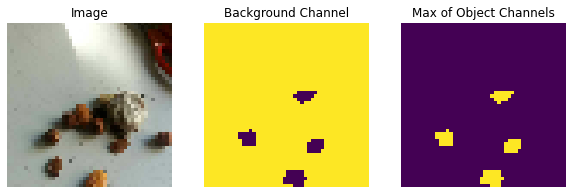

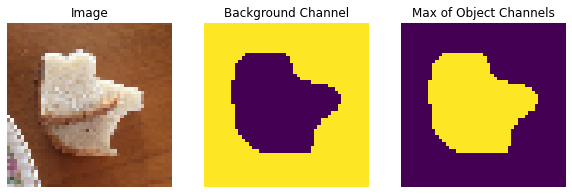

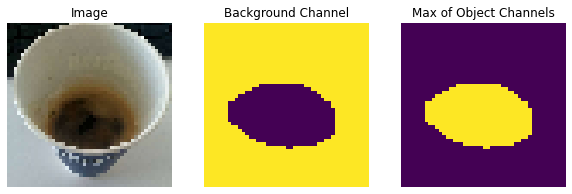

In [11]:
# Visualise a few samples images with their backgrounds and objects
visualise(train_imgs_path, train_coco, train_classes, IMAGE_SIZE, 3)

In [12]:
# Install and import the segmentation models library
!pip install segmentation_models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

     |████████████████████████████████| 50 kB 1.3 MB/s 
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [13]:
# Define the model to be trained
model = sm.PSPNet('resnet152', encoder_weights='imagenet', encoder_freeze=True, 
                  input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), downsample_factor=4, 
                  classes=274, activation='softmax')

model.compile('Adam', loss=sm.losses.cce_dice_loss, 
              metrics=[sm.metrics.IOUScore(), sm.metrics.Precision(), sm.metrics.Recall()])

234332160/234326024 [==============================] - 5s 0us/step


In [14]:
# # Load the trained model weights
# weights_path = '../input/food-recognition-model/weights.h5'
# model.load_weights(weights_path)

In [15]:
# Train the defined model on the dataset
history = model.fit(train_gen, steps_per_epoch=train_length//BATCH_SIZE, 
                    validation_data=val_gen, validation_steps=val_length//BATCH_SIZE, 
                    epochs=EPOCHS)

Epoch 1/10
80/80 [==============================] - 725s 9s/step - loss: 0.9953 - iou_score: 0.0086 - precision: 0.0166 - recall: 0.3753 - val_loss: 1.0052 - val_iou_score: 0.0027 - val_precision: 0.0084 - val_recall: 0.3631
Epoch 2/10
80/80 [==============================] - 508s 6s/step - loss: 0.9660 - iou_score: 0.0267 - precision: 0.0609 - recall: 0.4078 - val_loss: 1.0104 - val_iou_score: 0.0026 - val_precision: 0.0203 - val_recall: 0.3720
Epoch 3/10
80/80 [==============================] - 525s 7s/step - loss: 0.9447 - iou_score: 0.0420 - precision: 0.0909 - recall: 0.4343 - val_loss: 0.9764 - val_iou_score: 0.0350 - val_precision: 0.1051 - val_recall: 0.3643
Epoch 4/10
80/80 [==============================] - 504s 6s/step - loss: 0.8666 - iou_score: 0.1209 - precision: 0.2626 - recall: 0.4330 - val_loss: 0.7628 - val_iou_score: 0.2497 - val_precision: 0.6035 - val_recall: 0.3738
Epoch 5/10
80/80 [==============================] - 499s 6s/step - loss: 0.7007 - iou_score: 0.2909 

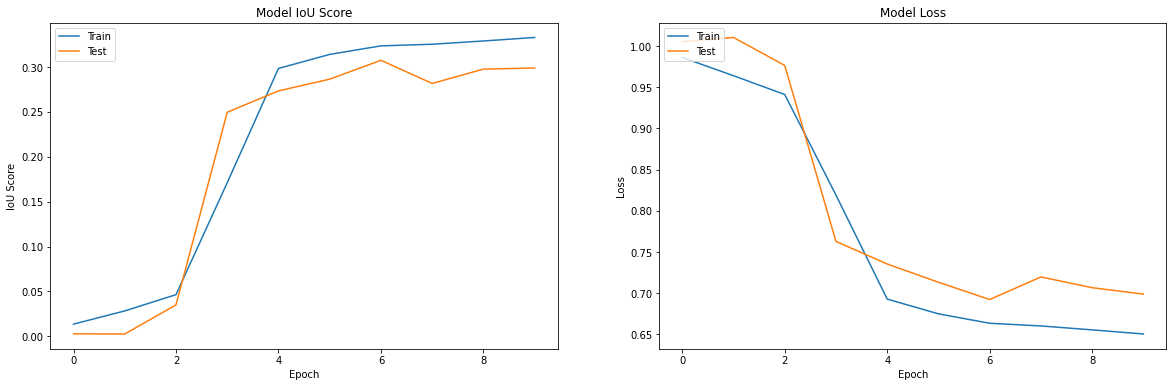

In [16]:
# Plot the loss and iou score over the epochs
plt.figure(figsize=(20, 6))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model IoU Score')
plt.ylabel('IoU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
# # Save the model to the output
# model.save_weights('weights.h5')

In [18]:
# Evaluate the model on the test generator
scores = model.evaluate(test_gen, steps=test_length//BATCH_SIZE)
print('\nLoss: {}'.format(round(scores[0], 3)))
print('Average IoU: {}'.format(round(scores[1], 3)))
print('Average Precision: {}'.format(round(scores[2], 3)))
print('Average Recall: {}'.format(round(scores[3], 3)))

4/4 [==============================] - 29s 9s/step - loss: 0.6941 - iou_score: 0.3041 - precision: 0.6683 - recall: 0.4113

Loss: 0.694
Average IoU: 0.304
Average Precision: 0.668
Average Recall: 0.411


In [19]:
def predict(model, path, coco, classes, image_size, batch_size):
    temp_gen = getGenerator(path, coco, classes, image_size, batch_size)
    images, masks = next(temp_gen)
    prediction = model.predict(images)
    
    for i in range(batch_size):
        plt.figure(figsize=(10, 20))
        
        plt.subplot(1, 3, 1)
        plt.title('Image')
        plt.imshow(images[i])
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        plt.imshow(np.max(masks[i][:, :, 1:], axis=2))
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(np.max(prediction[i][:, :, 1:], axis=2))
        plt.axis('off')
        
        plt.show()

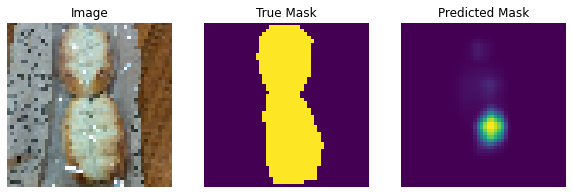

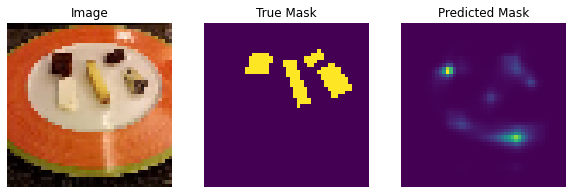

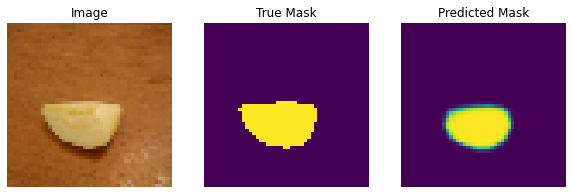

In [20]:
# Visualise the predictions and the true masks
predict(model, test_imgs_path, test_coco, test_classes, IMAGE_SIZE, 3)